<a href="https://colab.research.google.com/github/gurpreetschohan/CongressionalNotebook/blob/main/CongressionalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas
import numpy as np
import seaborn as sns

Our hypothesis is younger households relate more with democratic ideals and more likely to live in democratic districts. 

First we will read the ACS 2021 dataset and get it into a usable state for our data analysis.

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E,B01002_001E,B01002_002E,B01002_003E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in
# ata
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'Total Median Age', 'Male Median Age', 'Female Median Age','State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'Total Median Age', 'Male Median Age', 'Female Median Age','district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

,Total Households,Less than $10k,$200k+,Total Median Age,Male Median Age,Female Median Age,district number,State
0,287768,22411,12033,41.1,39.4,42.6,1,Alabama
1,267988,22053,10659,39.2,37.9,40.7,2,Alabama
2,285773,26313,9731,39.4,38.4,40.2,3,Alabama
3,265042,19087,10066,40.7,39.5,42.0,4,Alabama
4,312227,18511,24457,40.3,39.6,41.1,5,Alabama


In [ ]:

# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])
acs_df['Total Median Age'] = pd.to_numeric(acs_df['Total Median Age'])
acs_df['Male Median Age'] = pd.to_numeric(acs_df['Male Median Age'])
acs_df['Female Median Age'] = pd.to_numeric(acs_df['Female Median Age'])

# Compute some new columns based on the existing columns for later visualization
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']

# now let's look at the data again
acs_df.head()

,Total Households,Less than $10k,$200k+,Total Median Age,Male Median Age,Female Median Age,district number,State,% of households over $200k,% of households less than $10k
0,287768,22411,12033,41.1,39.4,42.6,1,Alabama,4.181493,7.787871
1,267988,22053,10659,39.2,37.9,40.7,2,Alabama,3.977417,8.229100
2,285773,26313,9731,39.4,38.4,40.2,3,Alabama,3.405150,9.207658
3,265042,19087,10066,40.7,39.5,42.0,4,Alabama,3.797889,7.201500
4,312227,18511,24457,40.3,39.6,41.1,5,Alabama,7.833083,5.928699


Now let's get our party affiliation data in a state to merge with the ACS data.

In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [ ]:
merged_df.describe()

,Total Households,Less than $10k,$200k+,Total Median Age,Male Median Age,Female Median Age,district number,% of households over $200k,% of households less than $10k
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,292471.643678,17605.977011,28522.944828,39.091954,37.999770,40.191724,10.158621,9.721602,6.050237
std,33670.787672,6047.931263,18902.411362,3.423247,3.269327,3.610044,10.656779,6.417955,2.106075
min,183319.000000,6021.000000,5296.000000,29.400000,28.900000,30.200000,0.000000,2.025905,2.208934
25%,273747.000000,13416.000000,14916.000000,37.000000,35.950000,37.950000,3.000000,5.184740,4.653305
50%,292311.000000,16617.000000,22543.000000,39.000000,37.900000,40.200000,6.000000,7.618205,5.679285
75%,311849.500000,21013.500000,37009.500000,40.900000,39.800000,42.100000,13.000000,12.689262,7.036059
max,448949.000000,44929.000000,111988.000000,55.400000,53.400000,57.100000,53.000000,41.846370,16.858153


Now let's graph a boxplot of the median ages within Republican, Democratic, and Libertarian districts. 

Mean age of Repulicans is greater than Democrats and has a wider spread. While Democrats have a younger median age and more closely knit. 

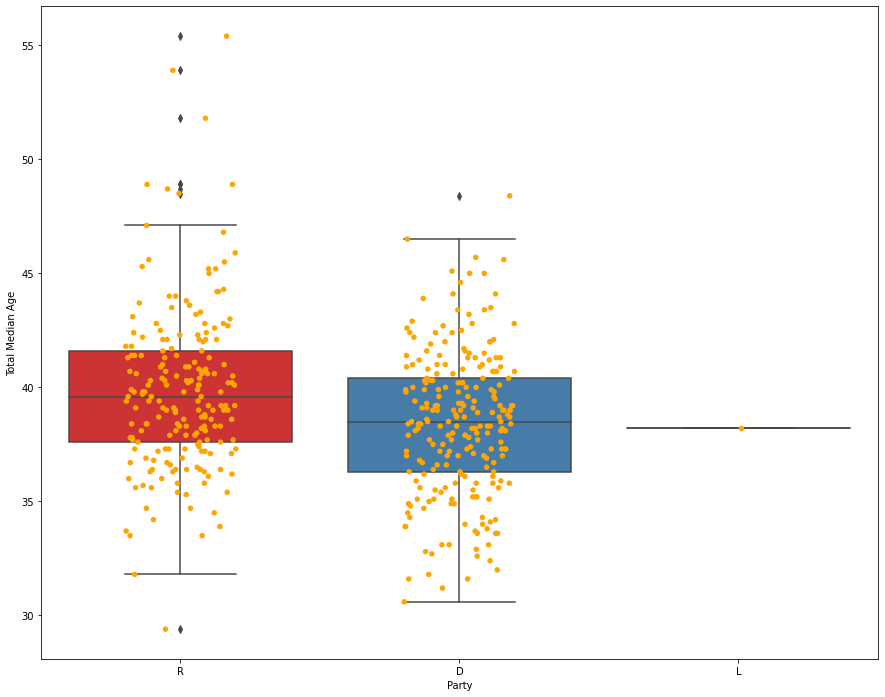

In [28]:
fig, ax = plt.subplots(figsize=(15, 12))

ax = sns.boxplot(x='Party', y='Total Median Age', data=merged_df, ax=ax,palette="Set1")

ax = sns.stripplot(x='Party', y='Total Median Age', data=merged_df, color="orange", jitter=0.2, size=5.5, ax=ax)


# show the graph
plt.show()


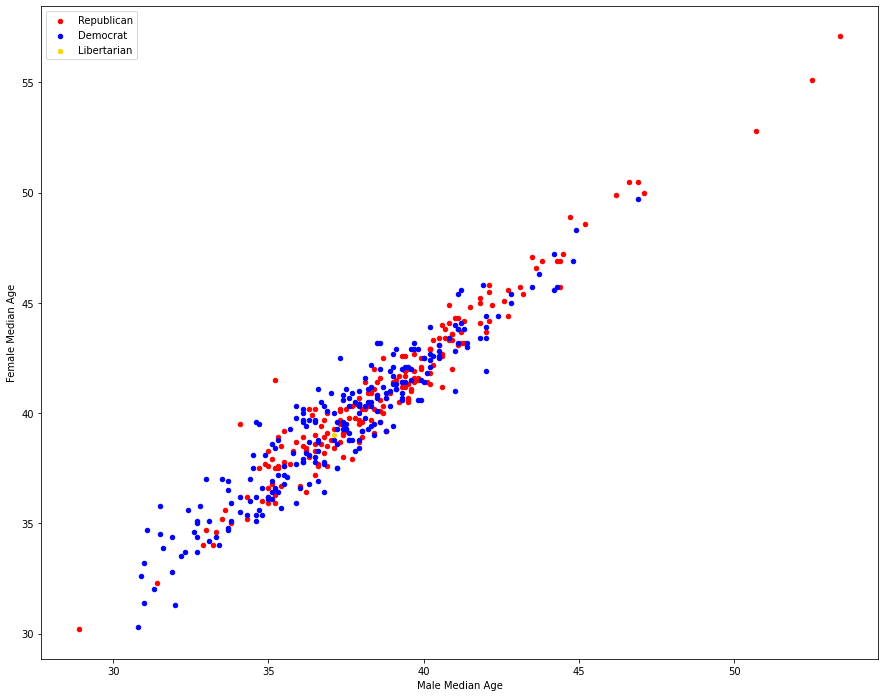

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='Male Median Age', y='Female Median Age', c='red',label='Republican', ax=ax)
D.plot.scatter(x='Male Median Age', y='Female Median Age',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='Male Median Age', y='Female Median Age',c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()

In [ ]:
merged_df.head()

,Total Households,Less than $10k,$200k+,Total Median Age,Male Median Age,Female Median Age,district number,State,% of households over $200k,% of households less than $10k,Party
0,287768,22411,12033,41.1,39.4,42.6,1,Alabama,4.181493,7.787871,R
1,267988,22053,10659,39.2,37.9,40.7,2,Alabama,3.977417,8.229100,R
2,285773,26313,9731,39.4,38.4,40.2,3,Alabama,3.405150,9.207658,R
3,265042,19087,10066,40.7,39.5,42.0,4,Alabama,3.797889,7.201500,R
4,312227,18511,24457,40.3,39.6,41.1,5,Alabama,7.833083,5.928699,R


This graph shows that the Republicans who are in red tend to have more volatile results. They have higher peaks and lower dips. This makes for dramatic differences in ages between the districts. Democrats tend to be much closer to each other on average and have much less dramatic spikes in ages. 

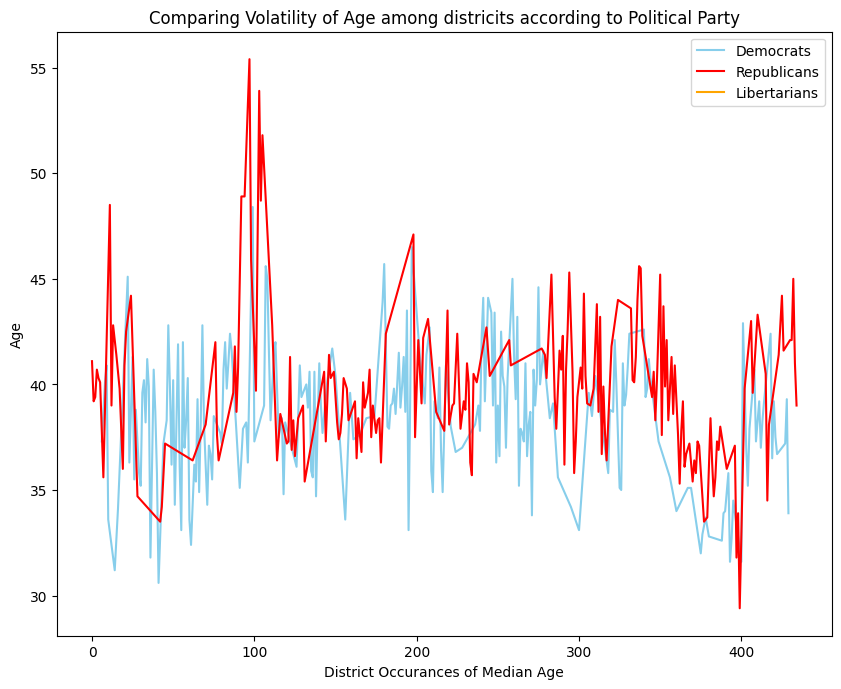

In [ ]:
 from matplotlib.pyplot import figure
 figure(figsize=(10, 8), dpi=100)
 
 Democrats_Age = merged_df[(merged_df.Party =="D")]
 Democrats_All_Ages = Democrats_Age['Total Median Age']

 Rebublicans_Age = merged_df[(merged_df.Party =="R")]
 Rebublicans_All_Ages = Rebublicans_Age['Total Median Age']

 Libertarian_Age = merged_df[(merged_df.Party =="L")]
 Libertarian_All_Ages = Libertarian_Age['Total Median Age']

# create data
values1 =(Democrats_All_Ages)
values2 =(Rebublicans_All_Ages)
values3 =(Libertarian_All_Ages)

# use the plot function
plt.plot(values1, color="skyblue", label='Democrats')
plt.plot(values2, color="red", label='Republicans')
plt.plot(values3, color="orange", label='Libertarians')


plt.xlabel('District Occurances of Median Age')
plt.ylabel('Age')
plt.title('Comparing Volatility of Age among districits according to Political Party')

plt.legend()
plt.show()

This graph gives us a clear answer. Democrats on average have younger households per district. However since this graph also shows that the difference is not very large. It's also important to note that there is only one libertarian district. Their party probably needs more data to be conclusive but that one district is younger than the averages for the Democrats. 

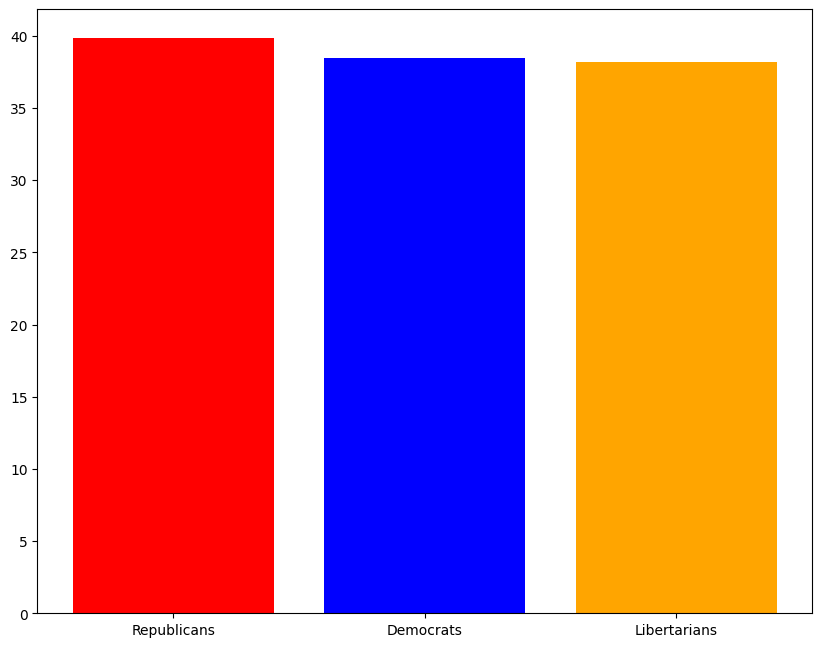

In [ ]:
 from matplotlib.pyplot import figure
 figure(figsize=(10, 8), dpi=100)

 Democrats_Age = merged_df[(merged_df.Party =="D")]
 Democrats_Avg_Age = sum(Democrats_Age['Total Median Age'])/len(Democrats_Age.index)

 Rebublicans_Age = merged_df[(merged_df.Party =="R")]
 Rebublicans_Avg_Age = sum(Rebublicans_Age['Total Median Age'])/len(Rebublicans_Age.index)

 Libertarian_Age = merged_df[(merged_df.Party =="L")]
 Libertarian_Avg_Age = sum(Libertarian_Age['Total Median Age'])/len(Libertarian_Age.index)


height = [Rebublicans_Avg_Age, Democrats_Avg_Age, Libertarian_Avg_Age]
bars = ('Republicans','Democrats','Libertarians')
x_pos = np.arange(len(bars))
plt.bar(x_pos, height, color=["red","blue","orange"])


plt.xticks(x_pos, bars)
plt.margins(0.05)
plt.show()